# Getting and preparing the data



To demonstrate the post processing algorithm we use the "Adult Data Set" from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/adult). The labels indicate whether a person makes more (label 1) or less (label 0) than $50k based on just a few attributes such as age, sex, race, education, occupation, etc.
For the purposes of this notebook, we can interpret this as a loan decision problem. The label indicates whether or not each individual repaid a loan in the past. We will use the data to train a model to predict whether previously unseen individuals will repay a loan or not. The assumption is that the model predictions are used to decide whether an individual should be offered a loan.

To start, let's download the dataset using `shap`

In [1]:
import pandas as pd
import numpy as np
import shap

X, y = shap.datasets.adult()
X.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


Since we need to encode categorical attributes properly, there are a few additional steps to take. We'll also split the data into train and test sets. The attribute we're interested in for the purpose of this notebook is `Sex`. Female is encoded as 0 and male as 1. Note: our approach works even for more than two groups, but the dataset didn't provide that information.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

group_data = X["Sex"]
X = pd.get_dummies(X)

y = LabelEncoder().fit_transform(y)


X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, 
                                                                     y, 
                                                                     group_data,
                                                                     test_size = 0.2,
                                                                     random_state=0,
                                                                     stratify=y)

X_train = X_train.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

# Create a fairness-unaware model


original training data:
P[loan approval | male]                    = 0.30627836176690215
P[loan approval | female]                  = 0.108924644056025

fairness-unaware prediction on training data:
P[loan approval | male]                    = 0.23487851111494054
P[loan approval | female]                  = 0.05891885634911448
P[loan approval | male, loan repaid]       = 0.5635783945986497
P[loan approval | female, loan repaid]     = 0.4038257173219979
P[loan approval | male, loan not repaid]   = 0.08975739008031795
P[loan approval | female, loan not repaid] = 0.01675759937646142

original test data:
P[loan approval | male]                    = 0.3035836566993837
P[loan approval | female]                  = 0.11163227016885553

fairness-unaware prediction on test data:
P[loan approval | male]                    = 0.23396484820817165
P[loan approval | female]                  = 0.05956848030018762
P[loan approval | male, loan repaid]       = 0.5466165413533834
P[loan approval | female,

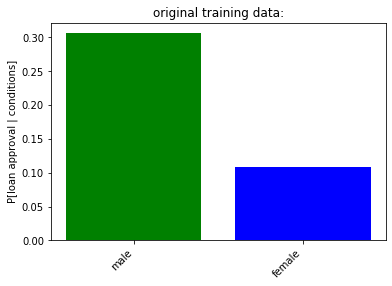

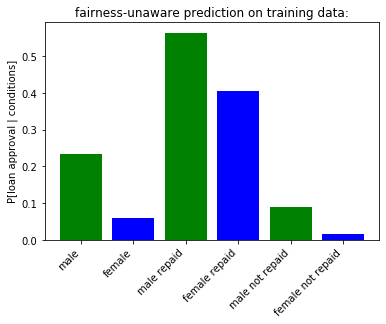

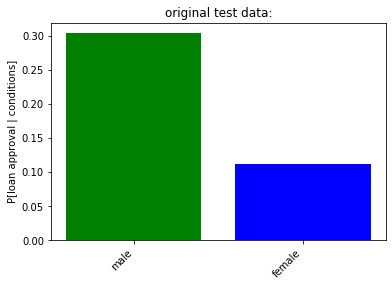

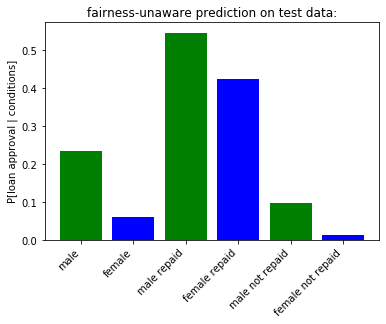

In [3]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

unconstrained_model = LogisticRegression(solver='liblinear')
unconstrained_model.fit(X_train, y_train)

def show_proportions(X, y_pred, y=None, description=None, plot_row_index=1):
    male_indices = X.index[X.Sex == 1]
    female_indices = X.index[X.Sex == 0]

    males_approved = sum(y_pred[male_indices])
    females_approved = sum(y_pred[female_indices])
    print("\n" + description)
    males_approved_pct = males_approved/len(male_indices)
    females_approved_pct = females_approved/len(female_indices)
    print("P[loan approval | male]                    = {}".format(males_approved_pct))
    print("P[loan approval | female]                  = {}".format(females_approved_pct))
    
    plt.figure(plot_row_index)
    plt.title(description)
    plt.bar(1, males_approved_pct, color='g')
    plt.bar(2, females_approved_pct, color='b')
    x_tick_labels = ["male", "female"]
    plt.ylabel("P[loan approval | conditions]")
    
    if y is not None:
        positive_male_indices = X.index[(X.Sex == 1) & (y == 1)]
        negative_male_indices = X.index[(X.Sex == 1) & (y == 0)]
        positive_female_indices = X.index[(X.Sex == 0) & (y == 1)]
        negative_female_indices = X.index[(X.Sex == 0) & (y == 0)]
        male_prob_1 = sum(y_pred[positive_male_indices])/len(positive_male_indices)
        female_prob_1 = sum(y_pred[positive_female_indices])/len(positive_female_indices)
        male_prob_0 = sum(y_pred[negative_male_indices])/len(negative_male_indices)
        female_prob_0 = sum(y_pred[negative_female_indices])/len(negative_female_indices)
        print("P[loan approval | male, loan repaid]       = {}".format(male_prob_1))
        print("P[loan approval | female, loan repaid]     = {}".format(female_prob_1))
        print("P[loan approval | male, loan not repaid]   = {}".format(male_prob_0))
        print("P[loan approval | female, loan not repaid] = {}".format(female_prob_0))

        plt.bar(3, male_prob_1, color='g')
        plt.bar(4, female_prob_1, color='b')
        plt.bar(5, male_prob_0, color='g')
        plt.bar(6, female_prob_0, color='b')
        x_tick_labels.extend(["male repaid", "female repaid", "male not repaid", "female not repaid"])
    
    plt.xticks(range(1, len(x_tick_labels)+1), x_tick_labels, rotation=45, horizontalalignment="right")
        
show_proportions(X_train, y_train, description="original training data:", plot_row_index=1)
show_proportions(X_train, unconstrained_model.predict(X_train), y_train, description="fairness-unaware prediction on training data:", plot_row_index=2)
show_proportions(X_test, y_test, description="original test data:", plot_row_index=3)
show_proportions(X_test, unconstrained_model.predict(X_test), y_test, description="fairness-unaware prediction on test data:", plot_row_index=4)
plt.show()

We notice a stark contrast in the predictions with males being a lot more likely to be predicted to get approved, similar to the original training data. However, there's even a disparity between the subgroup of males and females that are approved. When considering only the samples labeled with "loan not repaid" males are much more likely to be predicted to get approved than females. The test data shows a similar disparity.

In [4]:
from azureml.contrib.explain.model.visualize import FairnessDashboard

FairnessDashboard([unconstrained_model,unconstrained_model,unconstrained_model], X_test, y_test.tolist(), pd.DataFrame(A_test).values.tolist(), True, list(X_test.columns), [0, 1], ["Sex"])

ExplanationWidget(value={'predictedY': <map object at 0x10E2A170>, 'trainingData': [[1, 57.0, 4.0, 9.0, 2.0, 1…

# Post-processing the model to get a fair model

The idea behind post-processing is to alter the output of the fairness-unaware model to achieve fairness. The post-processing algorithm requires three input arguments:
- the matrix of samples X
- the vector of predictions y from the fairness-unaware model 
- the vector of group attribute values A (in our code we refer to it as `group_data`)

The goal is to make the output fair with respect to parity criteria. Our post-processing algorithm uses one of
- Demographic Parity (DP): $P[h(X)=\hat{y} | A=a] = P[h(X)=\hat{y}] \qquad \forall a, \hat{y}$
- Equalized Odds (EO): $P[h(X)=\hat{y} | A=a, Y=y] = P[h(X)=\hat{y}|Y=y] \qquad \forall a, \hat{y}$

where $h(X)$ is the prediction based on the input $X$, $\hat{y}$ and $y$ are labels, and $a$ is a group attribute value. In our example, we'd expect the post-processed model with DP to be balanced between sexes. EO does not make the same guarantees. Instead, it ensures that the parity between the subgroups of each sex with label 1 in the training set, and parity between the subgroups of each sex with label 0 in the training set. Applied to our scenario, this means that men and women with who have repaid their loan in the past are equally likely to be approved for a new loan (and therefore also equally likely to be rejected). Similarly, there is parity between men and women who have not repaid a loan, but we have no parity between the groups with different training labels. In mathematical terms:

$$
P[\text{loan approval} | \text{male, loan repaid}] = P[\text{loan approval} | \text{female, loan repaid}], \text{e.g. } 0.95\\
P[\text{loan approval} | \text{male, loan not repaid}] = P[\text{loan approval} | \text{female, loan not repaid}], \text{e.g. } 0.15
$$

but that also means that men (and women) of different subgroup based on training labels don't necessarily have parity:

$$
P[\text{loan approval} | \text{male, loan repaid}] = 0.95 \neq 0.15 = P[\text{loan approval} | \text{male, loan not repaid}]
$$

Assessing which disparity metric is indeed fair varies by application scenario.

In [5]:
# This wrapper around the unconstrained estimator serves the purpose of mapping the predict
# method to predict_proba so that we can use real values to get more accurate estimates.
class LogisticRegressionAsRegression:
    def __init__(self, logistic_regression_estimator):
        self.logistic_regression_estimator = logistic_regression_estimator
    
    def fit(self, X, y):
        self.logistic_regression_estimator.fit(X, y)
    
    def predict(self, X):
        # use predict_proba to get real values instead of 0/1, select only prob for 1
        scores = self.logistic_regression_estimator.predict_proba(X)[:,1]
        return scores

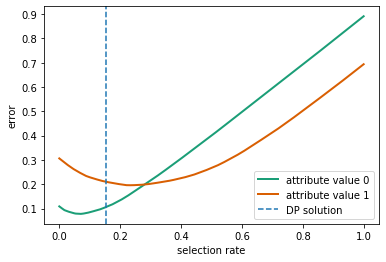


demographic parity with post-processed model on training data:
P[loan approval | male]                    = 0.1529668562237923
P[loan approval | female]                  = 0.15279546243778214
P[loan approval | male, loan repaid]       = 0.40678919729932483
P[loan approval | female, loan repaid]     = 0.722635494155154
P[loan approval | male, loan not repaid]   = 0.04090419806243272
P[loan approval | female, loan not repaid] = 0.0831384775266303

demographic parity with post-processed model on test data:
P[loan approval | male]                    = 0.15498744578863274
P[loan approval | female]                  = 0.15056285178236398
P[loan approval | male, loan repaid]       = 0.3969924812030075
P[loan approval | female, loan repaid]     = 0.6848739495798319
P[loan approval | male, loan not repaid]   = 0.049491969845952145
P[loan approval | female, loan not repaid] = 0.08342133051742344


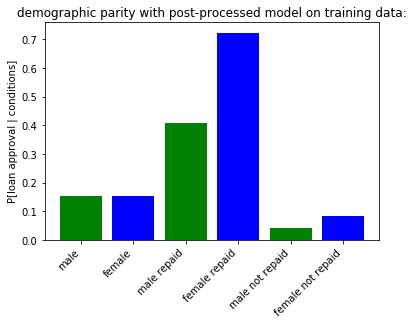

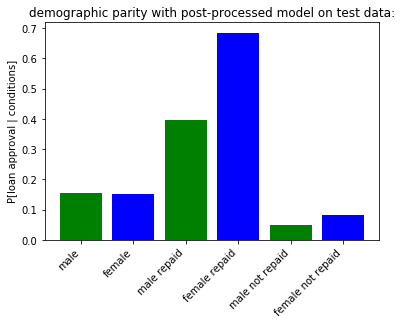

In [6]:
from fairlearn.post_processing import ThresholdOptimizer

unconstrained_model_wrapper = LogisticRegressionAsRegression(unconstrained_model)
post_processed_model_DP = ThresholdOptimizer(unconstrained_model=unconstrained_model_wrapper,
                                             parity_criteria="DemographicParity",
                                             plot=True,
                                             seed=0)

post_processed_model_DP.fit(X_train, y_train, group_data=X_train.Sex)

fairness_aware_predictions_DP_train = post_processed_model_DP.predict(X_train, group_data=X_train.Sex)
fairness_aware_predictions_DP_test = post_processed_model_DP.predict(X_test, group_data=X_test.Sex)

show_proportions(X_train, fairness_aware_predictions_DP_train, y_train, description="demographic parity with post-processed model on training data:", plot_row_index=1)
show_proportions(X_test, fairness_aware_predictions_DP_test, y_test, description="demographic parity with post-processed model on test data:", plot_row_index=2)

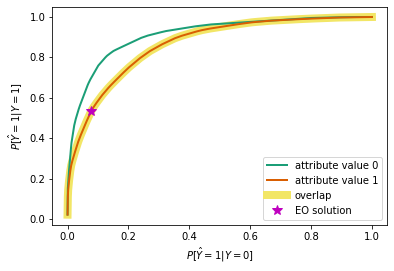


equalized odds with post-processed model on training data:
P[loan approval | male]                    = 0.21816301912803723
P[loan approval | female]                  = 0.12524597754369718
P[loan approval | male, loan repaid]       = 0.5354463615903976
P[loan approval | female, loan repaid]     = 0.5313496280552603
P[loan approval | male, loan not repaid]   = 0.07808230520824708
P[loan approval | female, loan not repaid] = 0.07560405300077942

equalized odds with post-processed model on test data:
P[loan approval | male]                    = 0.21410636840903904
P[loan approval | female]                  = 0.12617260787992496
P[loan approval | male, loan repaid]       = 0.5157894736842106
P[loan approval | female, loan repaid]     = 0.49159663865546216
P[loan approval | male, loan not repaid]   = 0.08259587020648967
P[loan approval | female, loan not repaid] = 0.08025343189017951


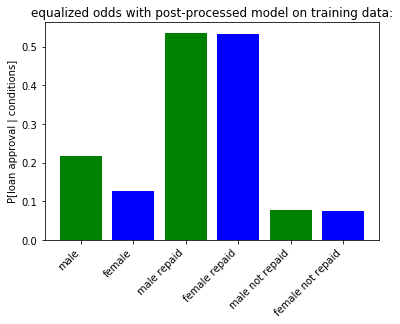

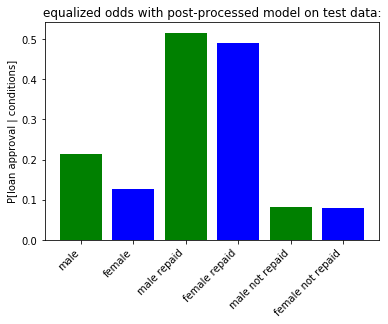

In [7]:
from fairlearn.post_processing import ThresholdOptimizer
from copy import deepcopy

unconstrained_model_wrapper = LogisticRegressionAsRegression(unconstrained_model)
post_processed_model_EO = ThresholdOptimizer(unconstrained_model=unconstrained_model_wrapper,
                                             parity_criteria="EqualizedOdds",
                                             plot=True,
                                             seed=0)

post_processed_model_EO.fit(X_train, y_train, group_data=X_train.Sex)

fairness_aware_predictions_EO_train = post_processed_model_EO.predict(X_train, group_data=X_train.Sex)
fairness_aware_predictions_EO_test = post_processed_model_EO.predict(X_test, group_data=X_test.Sex)

show_proportions(X_train, fairness_aware_predictions_EO_train, y_train, description="equalized odds with post-processed model on training data:", plot_row_index=1)
show_proportions(X_test, fairness_aware_predictions_EO_test, y_test, description="equalized odds with post-processed model on test data:", plot_row_index=2)

In [24]:
# Widget doesn't work with post processed models yet due to additional argument A
class PostProcessedModelWrapper:
    def __init__(self, predictor):
        self.predictor = predictor
    
    def predict(self, X):
        return self.predictor.predict(X, group_data=X.Sex)

FairnessDashboard([unconstrained_model,PostProcessedModelWrapper(post_processed_model_DP),PostProcessedModelWrapper(post_processed_model_EO)], X_test, y_test.tolist(), pd.DataFrame(A_test).values.tolist(), True, list(X_test.columns), [0, 1], ["Sex"])

ExplanationWidget(value={'predictedY': <map object at 0x1800FD10>, 'trainingData': [[1, 57.0, 4.0, 9.0, 2.0, 1…

# Post Processing in Detail

While this worked as the numbers show, it's not entirely obvious how it found its solution. The following section will provide a deep dive on post processing for both Demographic Parity (DP) and Equalized Odds (EO).

Our post processing method (based on work by [Hardt, Price, Srebro](https://arxiv.org/pdf/1610.02413.pdf)) takes a fairness-unaware model and a disparity metric (such as DP, or EO) in the constructor and features (X), labels (y), and auxiliary data (aux_data) in the fit method. It subsequently uses the model to make predictions for all samples in X. Note that these predictions could be 0/1 (as in our example), or more categories, or even real valued scores.
In our case, this looks as follows:

In [9]:
scores = unconstrained_model_wrapper.predict(X_train)
scores

array([0.02667692, 0.34292418, 0.41567237, ..., 0.05732434, 0.86857422,
       0.67104365])

## Finding threshold rules

The algorithm then tries to find all thresholding rules with which it could divide the data. Any score for which the thresholding rule evaluates to true is predicted to be 1. It does that for each group, so in this case once for male and once for female. Depending on your scores you could have lots of thresholding rules, between each set of such values. For each rule we just evaluate the following two probabilities empirically:

$$
P[\hat{Y} = 1 | Y = 0] \text{ which is labeled x below to indicate that it'll be plotted on the x-axis}\\
P[\hat{Y} = 1 | Y = 1] \text{ which is labeled y below to indicate that it'll be plotted on the y-axis}
$$

The former is the false negative rate (of that group), while the latter is the true positive rate (of that group). In our example, the threshold rules would be:  

In [10]:
from fairlearn.post_processing.threshold_optimizer import _reformat_and_group_data
data_grouped_by_attribute = _reformat_and_group_data(A_train, y_train, scores)
data_grouped_by_attribute.describe()

score                                                    \
             count      mean       std       min       25%       50%   
attribute                                                              
0           8639.0  0.119456  0.187907  0.000397  0.019592  0.043908   
1          17409.0  0.303269  0.276618  0.000552  0.064750  0.222672   

                            label                                               
                75%  max    count      mean       std  min  25%  50%  75%  max  
attribute                                                                       
0          0.121370  1.0   8639.0  0.108925  0.311563  0.0  0.0  0.0  0.0  1.0  
1          0.476337  1.0  17409.0  0.306278  0.460960  0.0  0.0  0.0  1.0  1.0

In [11]:
female_group = data_grouped_by_attribute.get_group(0)
male_group = data_grouped_by_attribute.get_group(1)
n_female = len(female_group)
n_male = len(male_group)
n_female, n_male

(8639, 17409)

In [12]:
from fairlearn.post_processing._roc_curve_utilities import _calculate_roc_points
roc_points_female = _calculate_roc_points(female_group, 0)
roc_points_female

,x,y,operation
0,0.000000,0.000000,[>inf]
1,0.000000,0.001063,[>0.9999999999999969]
2,0.000000,0.002125,[>0.9999999999999958]
3,0.000000,0.003188,[>0.999999999999994]
4,0.000000,0.005313,[>0.999999999999992]
5,0.000000,0.006376,[>0.9999999999999909]
6,0.000000,0.007439,[>0.9999999999999886]
7,0.000000,0.008502,[>0.9999999999999818]
8,0.000000,0.009564,[>0.999999999999971]
9,0.000000,0.010627,[>0.9999999999999571]


In [13]:
roc_points_male = _calculate_roc_points(male_group, 0)
roc_points_male

,x,y,operation
0,0.000000,0.000000,[>inf]
1,0.000000,0.000188,[>0.9999999999999992]
2,0.000000,0.000563,[>0.999999999999999]
3,0.000000,0.001313,[>0.9999999999999988]
4,0.000000,0.002251,[>0.9999999999999986]
5,0.000000,0.002813,[>0.9999999999999983]
6,0.000000,0.003938,[>0.9999999999999981]
7,0.000000,0.004501,[>0.9999999999999979]
8,0.000000,0.007314,[>0.9999999999999977]
9,0.000000,0.008627,[>0.9999999999999974]


The base points with (x,y) as (0,0) and (1,1) always exist, because that essentially just means that we're predicting everything as 0 or everything as 1 regardless of the scores from the fairness-unaware model. Let's look at both cases:
- x=0, y=0, threshold rule ">inf": more than infinity is impossible, which means every sample is predicted as 0. That means $P[\hat{Y} = 1 | Y = 0] = 0$ (represented as x) because our predictions $\hat(Y)$ are never 1, and similarly $P[\hat{Y} = 1 | Y = 1] = 0$ (represented as y).
- x=1, y=1, threshold rule ">-inf": more than infinity is always true, which means every sample is predicted as 1. That means $P[\hat{Y} = 1 | Y = 0] = 1$ (represented as x) because our predictions $\hat(Y)$ are always 1, and similarly $P[\hat{Y} = 1 | Y = 1] = 1$ (represented as y).

The more interesting logic happens in the third/middle case. Both adopted the thresholding rule $\geq0.5$. The x and y values were calculated as follows:

In [14]:
n_female_1 = sum(female_group["label"])
n_female_0 = len(female_group) - n_female_1
n_male_1 = sum(male_group["label"])
n_male_0 = len(male_group) - n_male_1
print("Female:")
print("    number of samples with label 1: {}".format(n_female_1))
print("    number of samples with label 0: {}".format(n_female_0))
print("Male:")
print("    number of samples with label 1: {}".format(n_male_1))
print("    number of samples with label 0: {}".format(n_male_0))

Female:
    number of samples with label 1: 941
    number of samples with label 0: 7698
Male:
    number of samples with label 1: 5332
    number of samples with label 0: 12077


In [15]:
x_female_0_5 = sum((female_group["score"] > 0.5) & (female_group["label"] == 0)) / n_female_0
y_female_0_5 = sum((female_group["score"] > 0.5) & (female_group["label"] == 1)) / n_female_1
x_male_0_5 = sum((male_group["score"] > 0.5) & (male_group["label"] == 0)) / n_male_0
y_male_0_5 = sum((male_group["score"] > 0.5) & (male_group["label"] == 1)) / n_male_1
print("Female:")
print("    P[Ŷ = 1 | Y = 0] = {}".format(x_female_0_5))
print("    P[Ŷ = 1 | Y = 0] = {}".format(y_female_0_5))
print("Male:")
print("    P[Ŷ = 1 | Y = 0] = {}".format(x_male_0_5))
print("    P[Ŷ = 1 | Y = 0] = {}".format(y_male_0_5))

Female:
    P[Ŷ = 1 | Y = 0] = 0.01675759937646142
    P[Ŷ = 1 | Y = 0] = 0.4038257173219979
Male:
    P[Ŷ = 1 | Y = 0] = 0.08975739008031795
    P[Ŷ = 1 | Y = 0] = 0.5635783945986497


Note that it never makes sense to have $x>y$ because in that case you're better off flipping labels, i.e. completely turning around the meaning of the scores. Our method automatically does that unless specified otherwise.

## Interpolated Predictions and Probabilistic Classifiers

This way you end up with a set of points above the diagonal line connecting (0,0) and (1,1). We calculate the convex hull based on that, because we can reach any point in between two known thresholding points by interpolation. An interpolation could be $p_0 (x_0, y_0) + p_1 (x_1, y_1)$. For our post processing algorithm that would mean that we use the rule defined by $(x_0, y_0, \text{operation}_0)$ $p_0$ percent of the time, and the rule defined by $(x_1, y_1, \text{operation}_1)$ $p_1$ percent of the time, thus resulting in a probabilistic classifier. Depending on the data certain fairness objectives can only be accomplished with probabilistic classifiers. However, not every use case lends itself to probabilistic classifiers, since it could mean that two people with identical features are classified differently.

## Finding the Equalized Odds solution

In this specific instance we don't need to do any extra work to get the convex hull, since there's only one point above the diagonal line.

Text(0, 0.5, '$P[\\hat{Y}=1|Y=1]$')

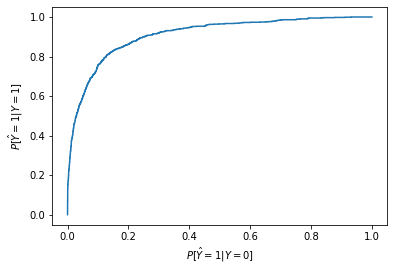

In [16]:
import matplotlib.pyplot as plt

plt.plot(roc_points_female.x, roc_points_female.y)
plt.xlabel("$P[\\hat{Y}=1|Y=0]$")
plt.ylabel("$P[\\hat{Y}=1|Y=1]$")

Text(0, 0.5, '$P[\\hat{Y}=1|Y=1]$')

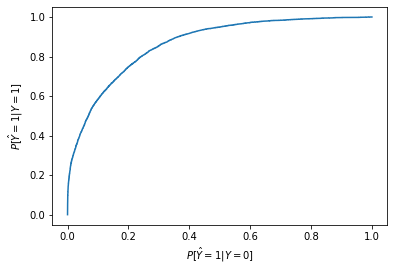

In [17]:
plt.plot(roc_points_male.x, roc_points_male.y)
plt.xlabel("$P[\\hat{Y}=1|Y=0]$")
plt.ylabel("$P[\\hat{Y}=1|Y=1]$")

In the Equalized Odds case, we need to enforce the presented probabilities to match, which is equivalent to finding the minimum error overlap. The error in the chart is smallest in the top left corner. This is done as part of the `fit` step above, and we'll repeat it here for completeness. The yellow area is the overlap between the areas under the curve that are reachable with interpolation for both groups. Of course, this works for more than two groups as well. The result is that we have interpolated solutions for each group, i.e. every prediction is calculated as the weighted result of two threshold rules.

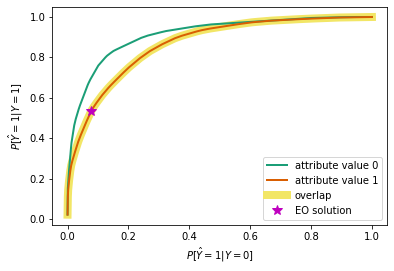

In [18]:
post_processed_model_EO.fit(X_train, y_train, group_data=X_train.Sex)

We can actually even look up the specific interpolations and interpret the results. Keep in mind that these interpolations come up with a floating point number between 0 and 1, and represent the probability of getting 0 or 1 in the predicted outcome.

For female samples 95% of the predicted outcome depends on a score above 0.5, while they start with a 5% probability regardless of the score. That means that any female with a score above 0.5 is virtually guaranteed to be approved for a loan.

For male samples there's always a 23% chance of not getting the loan regardless of the score, and if their score is below 0.5 they have no chance of approval.

Note that this does not necessarily mean it's fair. It simply enforced the constraints we asked it to enforce, as described by Equalized Odds.

The parameters `p_ignore` and `prediction_constant` are irrelevant for cases where the curves intersect in the minimum error point. When that doesn't happen, and the minimum error point is only part of one curve, then the interpolation is adjusted as follows
```
p_ignore * prediction_constant + (1 - p_ignore) * (p0 * operation0(score) + p1 * operation1(score))
```
The adjustment should happen to the higher one of the curves and essentially brings it closer to the diagonal as represented by `prediction_constant`. In our case this is not required since the curves intersect, but we are actually slightly inaccurate because we only determine the minimum error point on a grid of x values, instead of calculating the intersection point analytically. By choosing a large `gridsize` this can be alleviated.

In [19]:
for group, interpolation in post_processed_model_EO._post_processed_model_by_attribute.items():
    print("female:" if group == 0 else "male:")
    print("\n ".join(interpolation.__repr__().split(',')))
    print("-----------------------------------")

female:
[p_ignore: 0.26346627590631616
  prediction_constant: 0.078
  p0: 0.820472906403941
  operation0: [>0.2428419240785232]
  p1: 0.179527093596059
  operation1: [>0.19725908249011734]]
-----------------------------------
male:
[p_ignore: 0.0
  prediction_constant: 0.078
  p0: 0.00859482758620665
  operation0: [>0.5770835846395916]
  p1: 0.9914051724137933
  operation1: [>0.5263277146433339]]
-----------------------------------


## Finding the Demographic Parity solution

In the Demographic Parity case we can't exactly use the same x and y, since we're not conditioning on the labels in the training data. Instead, we only care about the probabilities of the predicted outcomes. That's why in that case we plot the selection rate (= percentage of predicted 1s) on the x-axis and the error rate on the y-axis. Some of the steps on the way are actually identical. We calculate the convex hull the same way. From the probabilities in that data we can calculate the probability of getting a prediction with label 1:

$$
P[\hat{Y} = 1] = \dfrac{n_1 P[\hat{Y} = 1 | Y = 1] + n_0 P[\hat{Y} = 1 | Y = 0]}{n}
$$

and we calculate the error rate:
$$
P[\hat{Y} \neq Y] = \dfrac{n_0 P[\hat{Y} = 1 | Y = 0] + n_1 P[\hat{Y} = 0 | Y = 1]}{n}
$$

To show the graph again we'll repeat the `fit` step from above. The chosen solution is where the sum of the errors weighted by the number of samples per group is minimized. In this example we have a lot more men than women in the dataset, which explains why it's choosing the selection rate at the point where it minimizes the error for the male curve.

Note that the error is explicitly plotted this time, so lower y-values are preferable.

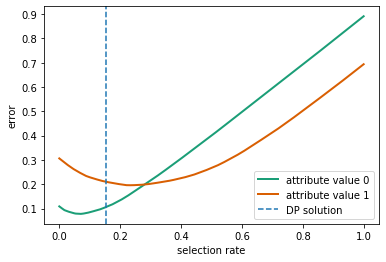

In [20]:
post_processed_model_DP.fit(X_train, y_train, group_data=X_train.Sex)

In [21]:
for group, interpolation in post_processed_model_DP._post_processed_model_by_attribute.items():
    print("female:" if group == 0 else "male:")
    print("\n ".join(interpolation.__repr__().split(',')))
    print("-----------")

female:
[p_ignore: 0
  prediction_constant: 0
  p0: 0.5845092936802976
  operation0: [>0.2428419240785232]
  p1: 0.4154907063197024
  operation1: [>0.19725908249011734]]
-----------
male:
[p_ignore: 0
  prediction_constant: 0
  p0: 0.006468181818180944
  operation0: [>0.6554195691383276]
  p1: 0.993531818181819
  operation1: [>0.6324448926387827]]
-----------


We can interpret this solution in a similar way as before. Women have a 19% chance of getting the loan regardless of the score, whereas men have a 0.3% chance. Both men and women with scores over 0.5 are guaranteed to get a loan. Note that this does not necessarily mean it's fair. It simply enforced the constraints we asked it to enforce, as described by Demographic Parity. This increased probability for women balances out the much lower approval rate in the training data.